In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Define the model (AllenAI OLMoE-1B-7B)
MODEL_ID = "AllenAI/OLMoE-1B-7B-0924"

# Configure 4-bit quantization to save memory
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

print(f"Loading {MODEL_ID}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=quant_config,
    device_map="auto"
)
print(f"Success! Model loaded on {model.device}")

/usr/local/lib64/python3.12/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.sparse import csr_matrix, issparse


Loading AllenAI/OLMoE-1B-7B-0924...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Success! Model loaded on cuda:0


In [2]:
# Dictionary to store the router outputs
router_logs = {}

def get_router_hook(layer_name):
    def hook(module, inputs, outputs):
        # Robustly handle tuple vs tensor outputs
        # OLMoE routers often return a tuple where [1] is the logits
        if isinstance(outputs, tuple):
            val = outputs[1] 
        else:
            val = outputs
        
        # Only capture if it matches the expert count (64 for OLMoE)
        if isinstance(val, torch.Tensor) and val.shape[-1] == 64:
            # Detach and move to CPU to save GPU memory
            router_logs[layer_name] = val.detach().float().cpu()
    return hook

# Clear old hooks (if re-running)
for name, module in model.named_modules():
    if hasattr(module, "_forward_hooks"):
        module._forward_hooks.clear()

# Attach new hooks to the router layers
print("Attaching spy hooks...")
hook_count = 0
for name, module in model.named_modules():
    # We target the specific gate layer in the OLMoE architecture
    if name.endswith("mlp.gate"): 
        module.register_forward_hook(get_router_hook(name))
        hook_count += 1

print(f"Attached {hook_count} hooks (Expect 32 for this model).")

Attaching spy hooks...
Attached 16 hooks (Expect 32 for this model).


{'input_ids': tensor([[  510,  3158,  8516, 30013, 27287,    15, 41514,   219,   167,   216,
           232, 29470, 29597,   118, 42170,    15,   209, 10446, 13639,  5444,
         23826,  6418,    15]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12371 (\N{HIRAGANA LETTER KO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12435 (\N{HIRAGANA LETTER N}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/gusohseb@GU.GU.SE/.local/lib/python3.12/site-packages/seaborn/utils.py

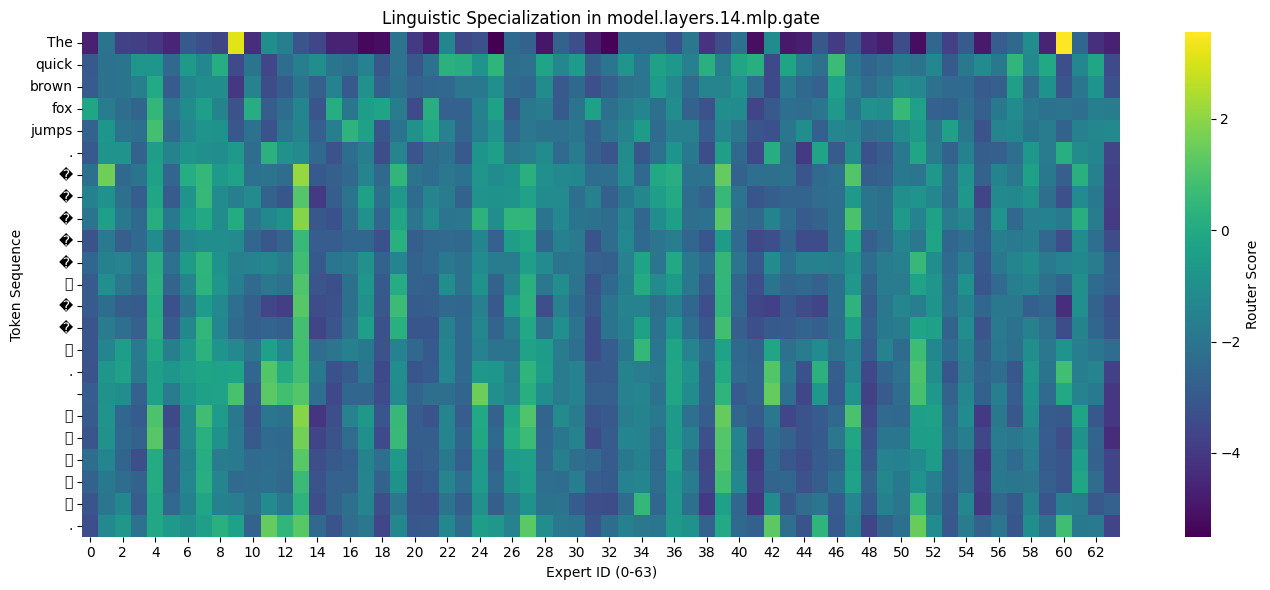

TOKEN           | TOP EXPERT
------------------------------
The             | 60
quick           | 46
brown           | 4
fox             | 50
jumps           | 4
.               | 11
�               | 13
�               | 13
�               | 13
�               | 13
�               | 13
하               | 13
�               | 13
�               | 13
요               | 13
.               | 42
                | 24
こ               | 13
ん               | 13
に               | 13
ち               | 39
は               | 51
.               | 51


In [3]:
# Run a sample inference
input_text = "Hello, how are you?"
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=10)

# Visualize the routing
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the routing distribution for each hook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define a Multilingual Test Sentence
text = "The quick brown fox jumps. 안녕하세요. こんにちは."
inputs = tokenizer(text, return_tensors="pt").to(model.device)
print(inputs)

# 2. Run Inference
router_logs = {} # Clear previous logs
with torch.no_grad():
    outputs = model(**inputs)

# 3. Analyze a Deep Layer (Layer 14)
# Deep layers often show the strongest specialization
target_layer = "model.layers.14.mlp.gate"

if target_layer in router_logs:
    logits = router_logs[target_layer].numpy()
    
    # Handle potential shape differences (Batch vs No-Batch)
    if logits.ndim == 3:
        data = logits[0] # [Seq, Experts]
    else:
        data = logits

    # Get the text labels
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    token_labels = [tokenizer.convert_tokens_to_string([t]).strip() for t in tokens]
    
    # --- Visualization ---
    plt.figure(figsize=(14, 6))
    sns.heatmap(
        data, 
        cmap="viridis", 
        yticklabels=token_labels,
        cbar_kws={'label': 'Router Score'}
    )
    plt.title(f"Linguistic Specialization in {target_layer}")
    plt.xlabel("Expert ID (0-63)")
    plt.ylabel("Token Sequence")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print Top Experts
    print(f"{'TOKEN':<15} | {'TOP EXPERT'}")
    print("-" * 30)
    for t, expert_id in zip(token_labels, np.argmax(data, axis=-1)):
        print(f"{t:<15} | {expert_id}")

else:
    print(f"Layer {target_layer} not found. Captured: {list(router_logs.keys())[:3]}...")

In [4]:
from datasets import load_dataset
from collections import Counter, defaultdict
import json

In [5]:
# Clear previous logs
# Clear old hooks (if re-running)
router_logs = {}
for name, module in model.named_modules():
    if hasattr(module, "_forward_hooks"):
        module._forward_hooks.clear()

print("Attaching spy hooks...")
hook_count = 0

# Attach new hooks to the router layers
for name, module in model.named_modules():
    if name.endswith("mlp.gate"): 
        module.register_forward_hook(get_router_hook(name))
        hook_count += 1

print(f"Attached {hook_count} hooks (Expect 32 for this model).")

Attaching spy hooks...
Attached 16 hooks (Expect 32 for this model).


In [9]:
with open("test_data_cleaned.jsonl", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]

In [10]:
print(len(test_data))
print(test_data[0])

4000
{'lang': 'eng_Latn', 'text': '3189\nSociologist Steven Seidman, author of such books as Beyond the Closet and Romantic Longings, recently interviewed me about lesbian identities and the changing landscape of sexual politics.'}


In [20]:
from tqdm import tqdm
# language_expert count dictionary
language_expert_counts = defaultdict(Counter)

for item in tqdm(test_data, desc="Processing samples"):
    langs = item["lang"]
    text = item["text"]
    
    if isinstance(langs, str):
        langs = [langs]
        
    # Clear router logs before each inference
    router_logs.clear()

    # Run inference
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        _ = model(**inputs)

    # Analyze a specific layer (14)
    target_layer = "model.layers.14.mlp.gate"
    
    if target_layer in router_logs:
        logits = router_logs[target_layer] # [Seq, Experts]
        expert_ids = logits.argmax(dim=-1).view(-1).tolist()  # Top Experts

        # Count expert selection for each language tag
        for lang in langs:
            language_expert_counts[lang].update(expert_ids)

Processing samples: 100%|█████████████████████████████████████████████████████████| 4000/4000 [1:30:27<00:00,  1.36s/it]


In [23]:
for lang, counter in language_expert_counts.items():
    print(f"\nTop experts used in language: {lang}")
    for expert_id, count in counter.most_common(10):
        print(f"  Expert {expert_id}: {count} times")


Top experts used in language: eng_Latn
  Expert 33: 1552 times
  Expert 49: 1362 times
  Expert 60: 1327 times
  Expert 19: 1319 times
  Expert 63: 1134 times
  Expert 57: 1075 times
  Expert 37: 1004 times
  Expert 40: 895 times
  Expert 22: 874 times
  Expert 35: 796 times

Top experts used in language: bul_Cyrl
  Expert 13: 74343 times
  Expert 52: 1292 times
  Expert 47: 1208 times
  Expert 19: 1141 times
  Expert 60: 1052 times
  Expert 1: 713 times
  Expert 12: 651 times
  Expert 9: 525 times
  Expert 26: 516 times
  Expert 27: 501 times

Top experts used in language: kor_Hang
  Expert 13: 123316 times
  Expert 19: 18176 times
  Expert 47: 11344 times
  Expert 52: 4460 times
  Expert 34: 2629 times
  Expert 61: 2127 times
  Expert 39: 1293 times
  Expert 9: 1279 times
  Expert 12: 1206 times
  Expert 60: 1152 times

Top experts used in language: jpn_Jpan
  Expert 13: 618810 times
  Expert 24: 210613 times
  Expert 19: 146663 times
  Expert 36: 75346 times
  Expert 47: 66244 time

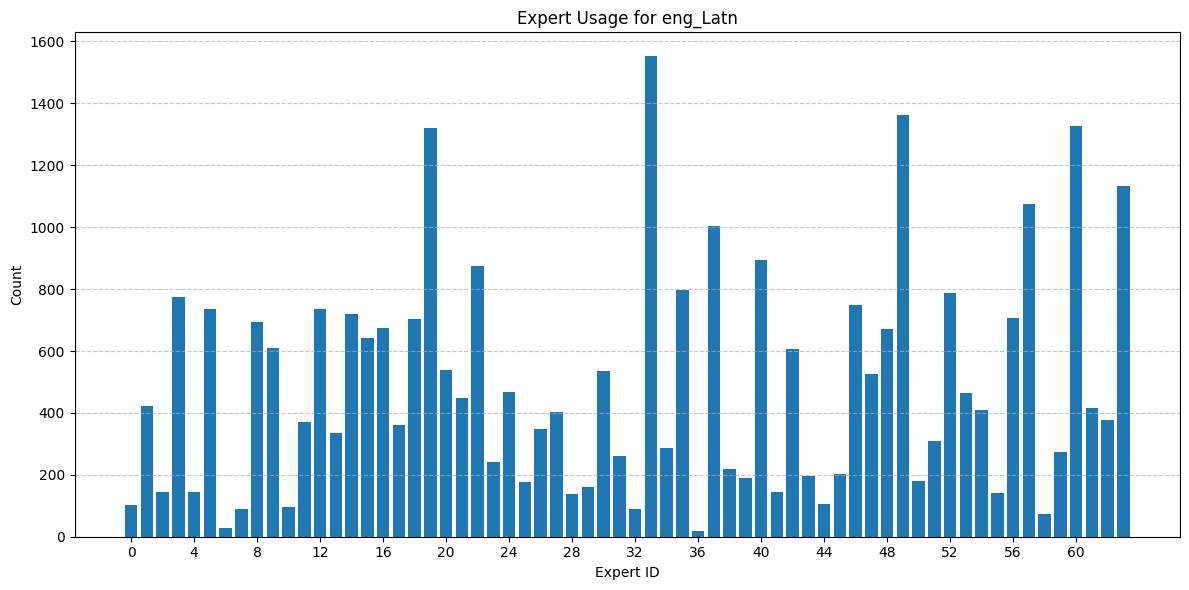

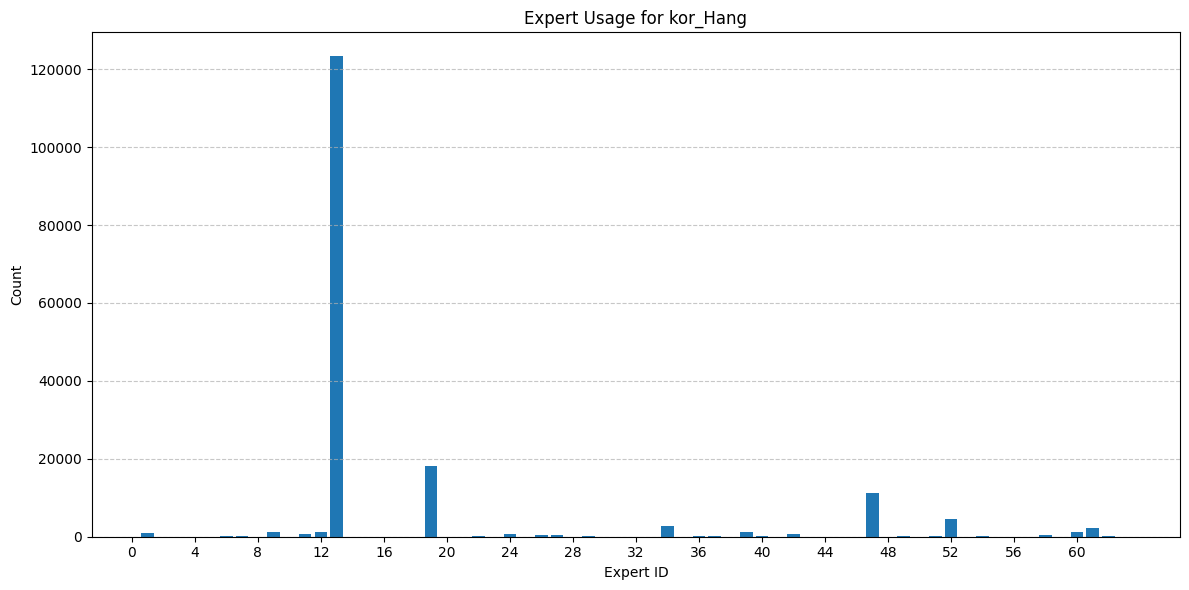

In [24]:
languages_to_plot = ['eng_Latn', 'kor_Hang']

for lang in languages_to_plot:
    if lang in language_expert_counts:
        counter = language_expert_counts[lang]

        expert_ids = list(counter.keys())
        counts = list(counter.values())

        plt.figure(figsize=(12, 6))
        plt.bar(expert_ids, counts)
        plt.title(f"Expert Usage for {lang}")
        plt.xlabel("Expert ID")
        plt.ylabel("Count")
        plt.xticks(range(0, 64, 4))
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Language {lang} not found in results.")

In [25]:
import csv

output_file = "language_expert_counts.csv"

with open(output_file, mode="w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(["language", "expert_id", "count"])
    
    for lang, counter in language_expert_counts.items():
        for expert_id, count in counter.items():
            writer.writerow([lang, expert_id, count])

print("Done")

Done
